# Import Libraries

In [17]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [18]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [19]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [20]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model


In [22]:
from models import Model_3
Net = Model_3

In [23]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,152
       BatchNorm2d-5           [-1, 16, 24, 24]              32
           Dropout-6           [-1, 16, 24, 24]               0
              ReLU-7           [-1, 16, 24, 24]               0
            Conv2d-8           [-1, 16, 22, 22]           2,304
       BatchNorm2d-9           [-1, 16, 22, 22]              32
             ReLU-10           [-1, 16, 22, 22]               0
        MaxPool2d-11           [-1, 16, 11, 11]               0
           Conv2d-12             [-1, 10, 9, 9]           1,440
      BatchNorm2d-13             [-1, 10, 9, 9]              20
          Dropout-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [24]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [25]:
model =  Net().to(device)
from torch.optim.lr_scheduler import StepLR
initial_learning_rate = 0.01  # Initial learning rate
epochs_per_update = 2  # Increase learning rate every 2 epochs
decay_rate = 0.9  # Rate of decay

# Define your optimizer
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=initial_learning_rate, momentum=0.9)


# Define your learning rate scheduler
scheduler = StepLR(optimizer, step_size=epochs_per_update, gamma=decay_rate)


In [26]:
# model =  Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

EPOCH: 0


Loss=0.07428374141454697 Batch_id=468 Accuracy=90.78: 100%|██████████| 469/469 [00:21<00:00, 21.51it/s]



Test set: Average loss: 0.0811, Accuracy: 9758/10000 (97.58%)

EPOCH: 1


Loss=0.0657760426402092 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]



Test set: Average loss: 0.0605, Accuracy: 9801/10000 (98.01%)

EPOCH: 2


Loss=0.08751850575208664 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:21<00:00, 21.58it/s]



Test set: Average loss: 0.0491, Accuracy: 9861/10000 (98.61%)

EPOCH: 3


Loss=0.01576346345245838 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:25<00:00, 18.75it/s]



Test set: Average loss: 0.0579, Accuracy: 9804/10000 (98.04%)

EPOCH: 4


Loss=0.05847880244255066 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:25<00:00, 18.66it/s]



Test set: Average loss: 0.0369, Accuracy: 9879/10000 (98.79%)

EPOCH: 5


Loss=0.07402526587247849 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:24<00:00, 19.05it/s]



Test set: Average loss: 0.0389, Accuracy: 9874/10000 (98.74%)

EPOCH: 6


Loss=0.027527131140232086 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:24<00:00, 19.07it/s]



Test set: Average loss: 0.0445, Accuracy: 9833/10000 (98.33%)

EPOCH: 7


Loss=0.08909473568201065 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:25<00:00, 18.22it/s]



Test set: Average loss: 0.0319, Accuracy: 9897/10000 (98.97%)

EPOCH: 8


Loss=0.021721696481108665 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]



Test set: Average loss: 0.0304, Accuracy: 9908/10000 (99.08%)

EPOCH: 9


Loss=0.026727229356765747 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:21<00:00, 21.63it/s]



Test set: Average loss: 0.0372, Accuracy: 9879/10000 (98.79%)

EPOCH: 10


Loss=0.013687093742191792 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:21<00:00, 21.74it/s]



Test set: Average loss: 0.0328, Accuracy: 9905/10000 (99.05%)

EPOCH: 11


Loss=0.04029393568634987 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:21<00:00, 21.54it/s]



Test set: Average loss: 0.0315, Accuracy: 9903/10000 (99.03%)

EPOCH: 12


Loss=0.04902048781514168 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:23<00:00, 20.11it/s]



Test set: Average loss: 0.0296, Accuracy: 9903/10000 (99.03%)

EPOCH: 13


Loss=0.023618029430508614 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:22<00:00, 21.03it/s]



Test set: Average loss: 0.0320, Accuracy: 9893/10000 (98.93%)

EPOCH: 14


Loss=0.006694881245493889 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:22<00:00, 20.57it/s]



Test set: Average loss: 0.0219, Accuracy: 9924/10000 (99.24%)

EPOCH: 15


Loss=0.019725540652871132 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:22<00:00, 20.74it/s]



Test set: Average loss: 0.0368, Accuracy: 9886/10000 (98.86%)

EPOCH: 16


Loss=0.02926691807806492 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:22<00:00, 20.44it/s]



Test set: Average loss: 0.0245, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.009893657639622688 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:22<00:00, 20.60it/s]



Test set: Average loss: 0.0226, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.0801585242152214 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:22<00:00, 20.46it/s]



Test set: Average loss: 0.0252, Accuracy: 9916/10000 (99.16%)

EPOCH: 19


Loss=0.021637314930558205 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:23<00:00, 20.02it/s]



Test set: Average loss: 0.0300, Accuracy: 9907/10000 (99.07%)

EPOCH: 20


Loss=0.013771314173936844 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:23<00:00, 19.99it/s]



Test set: Average loss: 0.0273, Accuracy: 9909/10000 (99.09%)

EPOCH: 21


Loss=0.01779842935502529 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:24<00:00, 19.23it/s]



Test set: Average loss: 0.0249, Accuracy: 9922/10000 (99.22%)

EPOCH: 22


Loss=0.06601842492818832 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:23<00:00, 20.24it/s]



Test set: Average loss: 0.0226, Accuracy: 9927/10000 (99.27%)

EPOCH: 23


Loss=0.05228610709309578 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:23<00:00, 20.10it/s]



Test set: Average loss: 0.0263, Accuracy: 9913/10000 (99.13%)

EPOCH: 24


Loss=0.0025076454039663076 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:22<00:00, 20.45it/s]



Test set: Average loss: 0.0239, Accuracy: 9928/10000 (99.28%)

EPOCH: 25


Loss=0.0422867052257061 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:23<00:00, 20.02it/s]



Test set: Average loss: 0.0286, Accuracy: 9907/10000 (99.07%)

EPOCH: 26


Loss=0.020372675731778145 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:23<00:00, 20.31it/s]



Test set: Average loss: 0.0238, Accuracy: 9915/10000 (99.15%)

EPOCH: 27


Loss=0.016178816556930542 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:23<00:00, 20.26it/s]



Test set: Average loss: 0.0266, Accuracy: 9915/10000 (99.15%)

EPOCH: 28


Loss=0.01469336822628975 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:22<00:00, 20.53it/s]



Test set: Average loss: 0.0241, Accuracy: 9930/10000 (99.30%)

EPOCH: 29


Loss=0.03625519573688507 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]



Test set: Average loss: 0.0267, Accuracy: 9916/10000 (99.16%)

EPOCH: 30


Loss=0.010574850253760815 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:22<00:00, 20.86it/s]



Test set: Average loss: 0.0254, Accuracy: 9924/10000 (99.24%)

EPOCH: 31


Loss=0.10837956517934799 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:24<00:00, 19.02it/s]



Test set: Average loss: 0.0224, Accuracy: 9933/10000 (99.33%)

EPOCH: 32


Loss=0.0701974555850029 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:23<00:00, 19.78it/s]



Test set: Average loss: 0.0275, Accuracy: 9915/10000 (99.15%)

EPOCH: 33


Loss=0.007953177206218243 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:23<00:00, 20.11it/s]



Test set: Average loss: 0.0249, Accuracy: 9923/10000 (99.23%)

EPOCH: 34


Loss=0.1261274814605713 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:23<00:00, 19.74it/s]



Test set: Average loss: 0.0244, Accuracy: 9924/10000 (99.24%)

EPOCH: 35


Loss=0.04723776876926422 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:23<00:00, 20.01it/s]



Test set: Average loss: 0.0246, Accuracy: 9924/10000 (99.24%)

EPOCH: 36


Loss=0.03718521073460579 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:23<00:00, 19.82it/s]



Test set: Average loss: 0.0258, Accuracy: 9923/10000 (99.23%)

EPOCH: 37


Loss=0.013386142440140247 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:22<00:00, 20.52it/s]



Test set: Average loss: 0.0238, Accuracy: 9932/10000 (99.32%)

EPOCH: 38


Loss=0.006077449768781662 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:23<00:00, 19.85it/s]



Test set: Average loss: 0.0236, Accuracy: 9928/10000 (99.28%)

EPOCH: 39


Loss=0.022748185321688652 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:24<00:00, 18.90it/s]



Test set: Average loss: 0.0241, Accuracy: 9926/10000 (99.26%)



Text(0.5, 1.0, 'Test Accuracy')

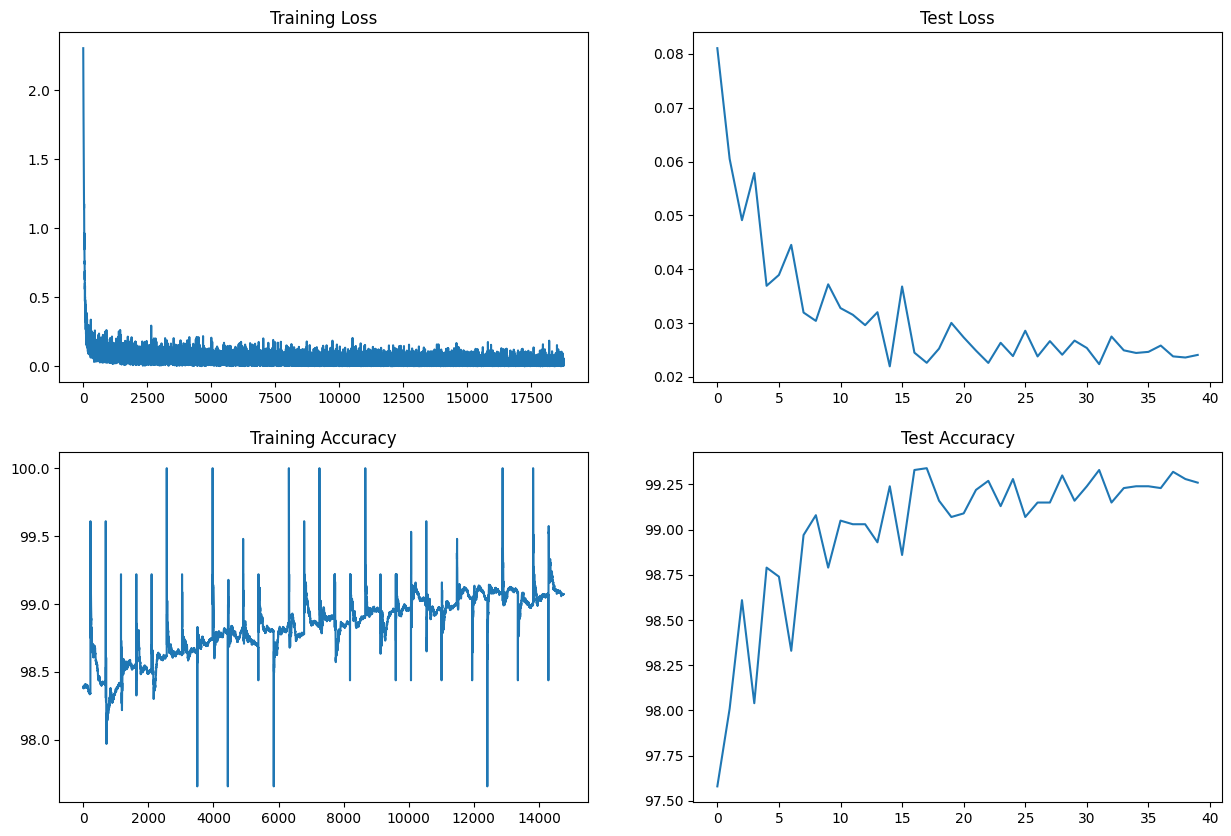

In [27]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Target:
  1. Add agumentations to images
  2. try to keep parameters below 8k
  3. Increase learning rate step by step and choosing better scheduler

Results:
  1. Parameters: 6k
  2. Best Train Accuracy:98.63
  3. Best Test Accuracy:99.24

Analysis:
  1. May be training for more than 40 epochs would reach 99.4 or increasing the number of parameters.
  2. 99.4 was not achieved consistently within 15 epochs but it gets to 99.4 accuracy consistently when trained for more than 40 epochs
  3. Image augmentation and modifying learning rate for every 2 epochs has given good improments.
  4. Adam optimizer works better than SGD

